In [3]:
import numpy as np
import tensorflow as tf
import random
import pickle
import scipy
import matplotlib.pyplot as plt
from d_u import load_CIFAR10
import structures
from amirata_functions import *
from pylab import rcParams
from tqdm import tqdm_notebook as tqdm
from CNN_class import CNN_SC
import scipy
import scipy.stats as stats
config_gpu = tf.ConfigProto()
config_gpu.gpu_options.allow_growth = True

In [4]:
data,aux_data = get_CIFAR10_data("../datasets/cifar-10-batches-py")
mean_image=data["mean_image"]

In [20]:
class CNN_points(object):
    
    def __init__(self,  num_centers, centers_dist, network_name,
                 num_conv_layers, num_forward_layers, input_shape,
                 num_classes, path,kernel_sizes, hidden_sizes, 
                 pool_sizes, dims, learning_rate = 0.001, 
                 padding = "SAME", initialize=False,dropout = 1, 
                 reject_cost = 0.2, activation="relu",reg = 0,
                 dynamic = False, batch_norm=True, loss_coeff=0):
        self.network_name = network_name
        self.centers_dist=centers_dist
        self.num_forward_layers = num_forward_layers
        self.num_conv_layers = num_conv_layers
        self.batch_norm = batch_norm
        self.input_shape = input_shape 
        #FIXIT: assumption is images are square
        self.dims = dims
        self.loss_coeff=loss_coeff
        self.padding = padding
        self.learning_rate = learning_rate
        self.pool_sizes = pool_sizes
        self.hidden_sizes = hidden_sizes
        self.kernel_sizes = kernel_sizes
        self.num_classed = num_classes
        self.dropout = dropout
        self.dynamic = dynamic
        self.num_classes = num_classes
        self.path = path
        self.reg = reg
        self.flatten_size = self.flatten_size_calculator()
        self.Pdic = self.make_Pdic()
        self.initialize = initialize
        self.num_centers=num_centers
        self.dropout_ph = tf.placeholder(tf.float32)
        self.input_ph = tf.placeholder\
        (dtype= tf.float32,shape= [None, self.input_shape[0],self.\
                                   input_shape[1],self.input_shape[2]])
        self.output_ph = tf.placeholder(dtype= tf.int32, shape= [None,])
        self.is_training_ph = tf.placeholder(tf.bool)
        self.activation = self.get_activation(activation)
        self.build(self.input_ph)
        
    def make_Pdic(self):
        
        Pdic = {}
        
        Pdic["W"] = tf.get_variable\
        ("W", shape = [self.hidden_sizes[self.num_forward_layers-1]\
                       ,self.num_classes],initializer=\
         tf.contrib.layers.xavier_initializer())
        Pdic["b"] = tf.get_variable("b", shape=[self.num_classes],\
                                    initializer=tf.zeros_initializer())
        
        self.sum_weights = tf.reduce_sum( Pdic["W"]**2)
        
        flat_length = self.flatten_size[self.num_conv_layers-1]
        
        for number in range(self.num_conv_layers):
            Pdic["K{}".format(number)] =  tf.get_variable\
            ("K{}".format(number),shape=[self.kernel_sizes[number]\
                                         ,self.kernel_sizes[number]\
                                         ,(number==0)*self.input_shape[-1]\
                                         + (number>0)*self.dims[number-1],\
                                         self.dims[number]],initializer=\
             tf.contrib.layers.xavier_initializer())
            Pdic["z{}".format(number)] = tf.get_variable\
            ("z{}".format(number), shape = [self.dims[number]],\
             initializer=tf.zeros_initializer())
        
        for layer in range(self.num_forward_layers):
            
            Pdic["W{}".format(layer)] = tf.get_variable\
            ("W{}".format(layer),shape=[flat_length*(layer==0)+\
                                        self.hidden_sizes[layer-1]*(layer>0)\
                                        ,self.hidden_sizes[layer]],
                                 initializer=\
             tf.contrib.layers.xavier_initializer())
            self.sum_weights += tf.reduce_sum( Pdic["W{}".format(layer)]**2)
            Pdic["b{}".format(layer)] = tf.get_variable\
            ("b{}".format(layer),shape=[self.hidden_sizes[layer]]\
             , initializer=tf.zeros_initializer())
        return Pdic
        


    def get_activation(self, name):
        if name == "relu":
            return tf.nn.relu
        if name == "tanh":
            return tf.nn.tanh
        if name == "sigmoid":
            return tf.sigmoid
    
    
    def conv_layer(self, number, feed):
        
        conv = tf.nn.conv2d(input=feed, filter=self.Pdic["K{}".format(number)]\
                            , padding="SAME", strides=[1,1,1,1])
        out_convv =\
        self.activation(conv + self.Pdic["z{}".format(number)])
        if self.batch_norm:
            out_conv = tf.layers.batch_normalization\
            (out_convv,axis=-1,training=self.is_training_ph)
        else:
            out_conv = out_convv
        pool = tf.layers.max_pooling2d\
        (inputs=out_conv, pool_size=self.pool_sizes[number],\
         strides=self.pool_sizes[number])
        return pool
    
    def fc_layer(self, layer, feed):
        out = tf.matmul(feed,self.Pdic["W{}".format(layer)])+\
        self.Pdic["b{}".format(layer)]
        out_relued = tf.nn.dropout(self.activation(out), 
                                   self.dropout_ph)
        return out_relued
    
    def flatten_size_calculator(self):
        if self.num_conv_layers:
            output = np.zeros(self.num_conv_layers)
            temp = self.input_shape[0]//self.pool_sizes[0]
            output[0] = temp*temp*self.dims[0]
            for n in range(1,self.num_conv_layers):
                temp = temp//self.pool_sizes[n]
                output[n] = temp*temp*self.dims[n]
        else:
            output = np.array([self.input_shape[0]*self.input_shape[1]*\
            self.input_shape[2]])
        return output.astype(int)
    
        
    def build(self, feed):
        # FIXIT: assumption is all convolutions are square
        out = feed
        for layer in range(self.num_conv_layers):
            out = self.conv_layer(layer, out)
        flat_length = self.flatten_size[self.num_conv_layers-1]
        out = tf.reshape(out, shape=[-1, flat_length])
        for layer in range(self.num_forward_layers):
            out = self.fc_layer(layer,out)
        self.hidden = out
        self.dic = {}
        
            
    def get_batches(self, training_data, batch_size, validation_data):   
        Xs = training_data[0]
        Ys = training_data[1]
        mask = np.random.permutation(len(Ys))
        Xs = Xs[mask]
        Ys = Ys[mask]
        X_batches = [Xs[k:k + batch_size] for k in range(0, len(Xs)\
                                                         , batch_size)]
        Y_batches = [Ys[k:k + batch_size] for k in range(0, len(Ys)\
                                                         , batch_size)]
        return X_batches, Y_batches, validation_data[0], validation_data[1]


    def do_epoch(self, sess, epoch, X_batches, Y_batches, X_val, Y_val,
                 X_train, Y_train, verbose):
        avg_cost = 0
        mskn = np.random.choice(range(X_train.shape[0]),len(X_val),replace=False)
        x_train = X_train[mskn]
        y_train = Y_train[mskn]
        for X_batch, Y_batch in zip(X_batches, Y_batches):
            sess.run(self.dic["optmz_h"],
                     feed_dict={self.input_ph:X_batch,
                                self.output_ph:Y_batch,
                                self.is_training_ph:True,
                               self.dropout_ph:self.dropout})
        val_h = sess.run(self.hidden,
                         feed_dict={self.input_ph:X_val,
                                    self.is_training_ph:False,
                                    self.dropout_ph:1})
        val_cost = sess.run(self.dic["cost_h"],
                            feed_dict={self.input_ph:X_val,
                                       self.output_ph:Y_val,
                                       self.is_training_ph:False,
                                       self.dropout_ph:1})
        acc, rate = self.evaluate(val_h,Y_val)
        tr_h = sess.run(self.hidden,
                        feed_dict={self.input_ph:x_train,
                                   self.is_training_ph:False,
                                   self.dropout_ph:1})
        tr_cost = sess.run(self.dic["cost_h"],
                           feed_dict={self.input_ph:x_train,
                                      self.output_ph:y_train,
                                      self.is_training_ph:False,
                                      self.dropout_ph:1})
        acc_train, _ = self.evaluate(tr_h,y_train)
        if verbose:
            print("Epoch:{}".format(epoch))
            print("Val/Train Accuracy:{}/{}".format(acc,acc_train))
            print("Val/Train Cost:{}/{}".format(val_cost,tr_cost))
            if rate<1:
                print("rate:{}").format(rate)
        return acc
    
    def tradeoff(self,sess, X_val, Y_val):
        self.acc_hist = []
        self.rate_hist = []
        self.thresh_list = []
        val_h = sess.run(self.hidden,\
                         feed_dict={self.input_ph:X_val,\
                                    self.is_training_ph:False,
                                    self.dropout_ph:1})
        r=0.
        thresh = 1e5*1.
        while(r<0.95):
            thresh /= 1.001
            self.thresh_list.append(thresh)
            a,r = self.evaluate(val_h,Y_val,thresh)
            r = 1-r
            self.acc_hist.append(a)
            self.rate_hist.append(r)
#                 print(thresh,a,r)
          
    def give_back_centers(self,X_train,y_train, num_centers, 
                          sess=None):
        if sess==None:
            sess=get_session()
            saver = tf.train.Saver()
            saver.restore(sess,self.path)  
        new_centers=np.zeros((self.num_classes,num_centers,
                              self.hidden_sizes[-1]))
        for i in range(self.num_classes):
            args = np.where(y_train==i)[0]
            args_center = np.random.choice(args,num_centers,
                                           replace=False)
            in_center=X_train[args_center]
            new_centers[i]=sess.run(self.hidden,
                                    feed_dict={self.input_ph:in_center,
                                              self.dropout_ph:1,
                                              self.is_training_ph:False})
        return new_centers
    
    def optimize(self, training_data, validation_data,
                 save, load , reg= 0, epochs=10,batch_size= 200, 
                 tradeoff=False, verbose=True, save_always=False, 
                 loss_coeff=0, centers=None):
        
        if np.size(centers)>1:
            centers_init=centers
        else:
            centers_init=self.centers_dist*\
            np.random.random((self.num_classes,self.num_centers,
                             self.hidden_sizes[-1]))
        self.centers_var=tf.cast(tf.Variable(centers_init),
                                 tf.float32)   
        labels = tf.cast(tf.one_hot(self.output_ph,self.num_classes),\
                         tf.float32)
        self.distances = tf_l2_distance_expert(self.hidden,
                                               self.centers_var)
        self.min_distance = tf.reduce_min(self.distances,axis=-1)
        self.which_center = tf.argmin(self.distances, axis=-1)
        self.dic["cost_h"] =\
        tf.reduce_mean(tf.reduce_sum(self.min_distance * labels,
                                     axis=1))-self.loss_coeff*\
        tf.reduce_sum(tf_self_distances(self.centers_var))\
        +0.5*self.reg*(self.sum_weights)
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):                                                                       
            self.dic["optmz_h"]= tf.train.AdamOptimizer\
            (self.learning_rate).minimize(self.dic["cost_h"])
            
        X_batches, Y_batches, X_val, Y_val = \
        self.get_batches(training_data, batch_size, validation_data)
        X_train = training_data[0]
        Y_train = training_data[1]
        saver = tf.train.Saver()
        init = tf.global_variables_initializer()
        
            
        with tf.Session(config=config_gpu) as sess:
            sess.run(init)
            print(sess.run(tf_self_distances(self.centers_var)))
#             new_centers=self.give_back_centers(X_train,Y_train,
#                                               self.num_centers,sess)
#             self.centers_var=tf.Variable(new_centers)
#             sess.run(tf.variables_initializer([self.centers_var]))
#             print(sess.run(tf_self_distances(self.centers_var)))
            if load:
                saver.restore(sess,self.path)
            self.centers,val_h = sess.run([self.centers_var,self.hidden],\
                             feed_dict={self.input_ph:X_val,\
                                        self.is_training_ph:False,
                                        self.dropout_ph:1})
            best_val, _ = self.evaluate(val_h,Y_val)
            if verbose:
                print("validation accuracy before starting",best_val)

            for epoch in range(epochs):
                print(np.linalg.norm\
                      (self.centers-sess.run(self.centers_var)))
                self.centers=sess.run(self.centers_var)
                acc = self.do_epoch(sess, epoch, X_batches, Y_batches,
                                    X_val, Y_val,X_train,
                                    Y_train, verbose)
                if acc>=best_val or save_always: #FIXIT
                    best_val = acc
                    saved_path = saver.save(sess, self.path)
                    if verbose and not save_always:
                        print("New best!")
            self.best_val = best_val 
            print("Best val accuracy:",self.best_val)
            saver.restore(sess,self.path)
            if tradeoff:
                self.tradeoff(sess, X_val, Y_val)

    def predict(self, hidden):
        index = -1
        counter = 0.
        correct = 0.
        out = np.zeros(hidden.shape[0])
        diff_tensor =\
        tf.minimum(tf_l2_distance_expert(tf.constant(hidden)
                                         ,self.centers_var),axis=-1)
        diff=sess.run(diff_tensor)
        out = np.argmin(diff,axis=1)
        return out
    
    def adversary(self, feed, mean_image, epsilon, true_label, 
                  mode="BIM",sess=None,max_iter=30,verbose=False,
                  alpha=1):
        feed=np.expand_dims(feed,axis=0)
        true_label=[true_label]
        if sess==None:
            sess=get_session()
            saver = tf.train.Saver()
            saver.restore(sess,self.path)
        net_dists = sess.run(self.min_distance,
                             feed_dict={self.input_ph:feed,
                                       self.dropout_ph:1.,
                                       self.is_training_ph:False})
        
        net_label= np.argmin(net_dists,1)
        fake_label=np.argmax(net_dists,1)
        if net_label!=true_label:
            if verbose:
                print("Network is already misclassifying")
            return 
        adv = feed
        iters=0
        cont=True
        changed_label=False
        while(cont and iters<max_iter):
            iters += 1
            if mode=="BIM":
                gradient = sess.run(tf.gradients(self.dic["cost_h"],
                                        self.input_ph)[0],
                                    feed_dict={self.input_ph:adv,
                                   self.is_training_ph:False,
                                   self.output_ph:true_label,
                                   self.dropout_ph:1})
                adv_temp = adv + alpha*np.sign(gradient)
            if mode=="ILLCM":
                gradient = sess.run(tf.gradients(self.dic["cost_h"],
                                        self.input_ph)[0],
                                    feed_dict={self.input_ph:adv,
                                   self.is_training_ph:False,
                                   self.output_ph:fake_label,
                                   self.dropout_ph:1})
                adv_temp = adv - alpha*np.sign(gradient)
            adv_temp=np.maximum(np.maximum(feed-epsilon,adv_temp),
                             -mean_image)
            
            adv=np.minimum(np.minimum(feed+epsilon,adv_temp),
                           255-mean_image)
            
            out_adv = sess.run(self.min_distance,
                             feed_dict={self.input_ph:adv,
                                       self.dropout_ph:1.,
                                       self.is_training_ph:False})
            confidence = np.min(out_adv,1)
            new_label = np.argmin(out_adv,1)
            if verbose:
                print("True label:",true_label,"New label:",
                     new_label,"Confidence:", confidence)
            if new_label!=true_label:
                changed_label=True
            if changed_label and confidence<1000:
                cont=False
        return adv, changed_label, confidence
            
    def evaluate(self, hidden, y, thresh=1e100):  
        correct = 0.
        diff = np.min(l2_distance_expert(hidden,self.centers),
                          axis=-1)
        passed = np.min(diff,1)<thresh
        passed_num = np.sum(passed)
        correct = np.argmin(diff,1) == y     
        return np.sum(correct*passed)*1./passed_num,\
    passed_num*1./y.shape[0]
    
    def feedforward(self, feed, sess=None):
        if sess==None:
            sess=get_session()
            saver = tf.train.Saver()
            saver.restore(sess,self.path)  
        output = sess.run\
        (self.hidden, {self.input_ph: feed,
                       self.is_training_ph : False,
                       self.dropout_ph:1})

In [24]:
training_data = (data["X_train"][:2000],data["y_train"][:2000])
validation_data1 = (aux_data["X_val1"],aux_data["y_val1"])
tf.reset_default_graph()
network_F = CNN_points(num_centers = 10, centers_dist=10,
                        network_name="network1",num_conv_layers=3,
                        num_forward_layers=1,input_shape=[32,32,3], 
                        reg = 1e-2,num_classes=10,kernel_sizes=[5,5,5],
                        hidden_sizes=[1024], pool_sizes=[2,2,2], 
                        padding = "same",path ="saved_networks/points_3",
                        loss_coeff=100,dims=[64,128,256], 
                        learning_rate = 1e-3, 
                        batch_norm = True, dropout = 1)
network_F.optimize(training_data, validation_data1, 
                   epochs=40, load = True, save = True)
            

7.68319e+07
INFO:tensorflow:Restoring parameters from saved_networks/points_3
validation accuracy before starting 0.5155
0.0
Epoch:0
Val/Train Accuracy:0.5175/0.9915
Val/Train Cost:-8572942336.0/-8572945920.0
New best!
3.4113
Epoch:1
Val/Train Accuracy:0.52/0.9935
Val/Train Cost:-8624424960.0/-8624429056.0
New best!
3.42159
Epoch:2
Val/Train Accuracy:0.5105/0.993
Val/Train Cost:-8676209664.0/-8676215808.0
3.43162
Epoch:3
Val/Train Accuracy:0.516/0.9955
Val/Train Cost:-8728298496.0/-8728303616.0
3.4414
Epoch:4
Val/Train Accuracy:0.52/0.998
Val/Train Cost:-8780691456.0/-8780694528.0
New best!
3.45094
Epoch:5
Val/Train Accuracy:0.52/0.998
Val/Train Cost:-8833386496.0/-8833393664.0
New best!
3.46026
Epoch:6
Val/Train Accuracy:0.5065/0.993
Val/Train Cost:-8886387712.0/-8886393856.0
3.46935
Epoch:7
Val/Train Accuracy:0.505/0.9975
Val/Train Cost:-8939696128.0/-8939700224.0
3.47824
Epoch:8
Val/Train Accuracy:0.5085/0.9975
Val/Train Cost:-8993310720.0/-8993316864.0
3.48693
Epoch:9
Val/Train Acc

In [181]:
network_F.adversary(aux_data["X_val2"][3],mean_image,4,
                    aux_data["y_val2"][3],mode="ILLCM",
                   verbose=True,alpha=1)

INFO:tensorflow:Restoring parameters from saved_networks/1C_3L_T


INFO:tensorflow:Restoring parameters from saved_networks/1C_3L_T


True label: [1] New label: [1] Confidence: [ 6151.04003906]
True label: [1] New label: [1] Confidence: [ 6583.11328125]
True label: [1] New label: [1] Confidence: [ 7061.31835938]
True label: [1] New label: [1] Confidence: [ 7446.57519531]
True label: [1] New label: [1] Confidence: [ 7455.21875]
True label: [1] New label: [1] Confidence: [ 7574.50390625]
True label: [1] New label: [1] Confidence: [ 7478.99902344]
True label: [1] New label: [1] Confidence: [ 7720.94238281]
True label: [1] New label: [1] Confidence: [ 7795.15234375]
True label: [1] New label: [1] Confidence: [ 7908.30859375]
True label: [1] New label: [1] Confidence: [ 7944.12109375]
True label: [1] New label: [1] Confidence: [ 8011.90136719]
True label: [1] New label: [1] Confidence: [ 8052.42089844]
True label: [1] New label: [1] Confidence: [ 8135.328125]
True label: [1] New label: [1] Confidence: [ 8145.66992188]
True label: [1] New label: [1] Confidence: [ 8191.0390625]
True label: [1] New label: [1] Confidence: [ 8

(array([[[[ -6.38991250e+01,  -6.71391000e+01,  -9.95475250e+01],
          [ -6.12976000e+01,  -6.94913250e+01,  -9.98008750e+01],
          [ -6.52357000e+01,  -6.83168250e+01,  -1.01545350e+02],
          ..., 
          [ -6.22537500e+01,  -6.03587250e+01,  -8.73814250e+01],
          [ -5.15653500e+01,  -6.07493000e+01,  -8.69332000e+01],
          [ -3.63482750e+01,  -5.55151000e+01,  -8.48278500e+01]],
 
         [[ -6.32286750e+01,  -6.63075500e+01,  -1.00293350e+02],
          [ -6.44595500e+01,  -6.74519500e+01,  -1.05370175e+02],
          [ -6.43390250e+01,  -7.11772250e+01,  -1.00005450e+02],
          ..., 
          [ -5.22552250e+01,  -5.92118500e+01,  -8.98616750e+01],
          [ -4.35204500e+01,  -5.26138250e+01,  -8.84553250e+01],
          [ -4.83135500e+01,  -5.34037250e+01,  -9.53843250e+01]],
 
         [[ -6.38231750e+01,  -6.76227750e+01,  -9.21649000e+01],
          [ -6.18138250e+01,  -5.54700250e+01,  -9.29213000e+01],
          [ -7.06145500e+01,  -6.50787

In [149]:
network_F.tradeoff(sess,aux_data["X_val2"][1:1000],
                   aux_data["y_val2"][1:1000])

In [150]:
network_F.acc_list

AttributeError: 'CNN_centers' object has no attribute 'acc_list'

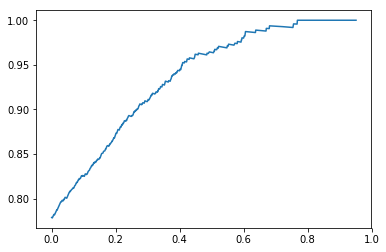

In [154]:
%matplotlib inline
plt.plot(network_F.rate_hist,network_F.acc_hist)